<a href="https://colab.research.google.com/github/Liping-LZ/BDAI_2324/blob/main/Forecasting/ARIMA%26SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Before we start**

In this notebook, you will learn about how to build ARIMA model to do time series forecasting with Python. First, we will have a quick introduction to ARIMA models and prepare you for understanding the models before using them; second, we will provide you step-by-step guidance regarding how ARIMA model is implemented with Python, from data preparation to modelling to prediction and evaluation.

### Hope you enjoy this notebook! Happy forecasting!

# **Introducing ARIMA model**

**ARIMA** stands for Autoregressive Integrated Moving Average Model. It is one of the most commonly used approaches to do time series forecasting. It is a forecasting algorithm following the idea that the information in the past values (i.e. its own lags or the lagged forecast errors) of the time series can alone be used to predict the future values.

There are three components within ARIMA model:

**AR** (stands for Autoregressive): Autoregressive model represents a regression or prediction of current value that is generated based on the past values from that same time series. That is to say, the value of today can be regressed on value of yesterday or the days before. The equation looks like this:
![image.png](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-1-min.png?ezimgfmt=ng:webp/ngcb1)

**I** (stands for Integration): Integration is to make sure the data is stationary since one of premises of applying ARIMA is that the data cannot show trends and should be stationary. This is because ARIMA is based on the idea that the forecaset is made with past value in the same time series and these values cannot be correlated which is usually required in regression model. If the data is not stationary, we will use differencing to transform the data, and this is what we call integration. Differencing involves the subtraction of the current values of a series with its previous values d number of times.


If d=0:  yt  =  Yt

If d=1:  yt  =  Yt - Yt-1

If d=2:  yt  =  (Yt - Yt-1) - (Yt-1 - Yt-2)  =  Yt - 2Yt-1 + Yt-2


**MA** (stands for Moving Average): Moving average model generates the current values based on the ERRORS from the past forecasts. The idea is similar to AR, but not using past values. The equation is as below:![image.png](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-2-min.png?ezimgfmt=ng:webp/ngcb1)

Thus, the equation of an ARIMA model becomes:![image.png](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min-865x77.png?ezimgfmt=ng:webp/ngcb1)


**ARIMA** Models are specified by three order parameters: (p, d, q),

where,

p is the order of the AR term, that means how many lagged observations (past values) are used as predictors

q is the order of the MA term, that means how many lagged forecasts errors (past forecast errors) should be considered

d is the number of differencing required to make the time series stationary


Now, you should have basic ideas of what ARIMA is and its key components. We will further explain some terms while implementing the forecast with data example.

### Let's start!


# **Implementation with data example**

## Install package

We will need pmarima package later for implementing ARIMA model. Here we install it first, so later we can import it directly.

In [22]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


## Data we use

In this tutorial we will be using an online retail dataset from UCI machine learning repository (https://archive.ics.uci.edu/dataset/502/online+retail+ii). Please download the data from the website and unzip the data. This dataset includes online retail transactions of two years (2009-2011). Here we will need to concat two years' data.

## Upload & Import data

In [ ]:
# by running this, you will be able to select the file from your laptop and upload it to Google cloud
# please wait until you see 100% done and the play button is resumed. it might take a while to upload because the dataset is large
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [1]:
import pandas as pd
df1 = pd.read_excel('online_retail_II.xlsx',sheet_name = 'Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx',sheet_name = 'Year 2010-2011')
df = pd.concat([df1,df2])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Data preparation

Based on the data here, we can use time series forecasting algorithm to forecast monthly sales of this online retail platform. But before we continue, we need to clean data and get it prepared for modelling.



**First**, we need to remove some noise data or unrelevant data. There are some negative values in quantity and price and this doesn't make sense for customer transaction data. If we check the data, we can find that some negative values are about bad debt adjustment, which is not the target of our forecasting.

**Second**, we need to create a new column called `Sales`, and we can get `Sales` by multiply `Quantity` and `Price`.

**Third**, we will only keep the date and the sales data, just to avoid unrelevant data in this case. And this will make it easier for the following steps.

**Lastly**, we need to group and aggregate the data into monthly data, so that we will be predicting monthly sales.

In [2]:
df.shape

(1067371, 8)

In [3]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

There are some null values in description. To avoid unclear items, we will remove them given the small number of missing value compared to the total number of data.

In [4]:
df.dropna(subset=['Description'],inplace=True)

By checking the duplicates, there are some duplicate rows, which is not common. Given it is 3% of the data, we will just drop them directly.

In [5]:
df.duplicated().sum()

34228

In [6]:
df = df.drop_duplicates()

Through descriptive analytics, we will see there are some negative values in "quantity" and "price" column, and the reason is not clear. We will further investigate.

In [7]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.028761e+06,1028761,1.028761e+06,797885.000000
mean,1.019092e+01,2011-01-04 01:16:01.831971328,4.633153e+00,15313.062777
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-05 14:41:00,1.250000e+00,13964.000000
50%,3.000000e+00,2010-12-09 14:09:00,2.100000e+00,15228.000000
75%,1.000000e+01,2011-07-27 15:16:00,4.150000e+00,16788.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.723738e+02,NaN,1.226512e+02,1696.466663


<Axes: >

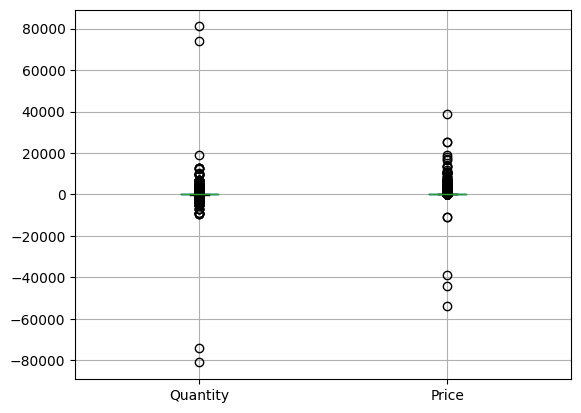

In [8]:
import matplotlib.pyplot as plt
# Create subplots for each column
df.boxplot(column = ['Quantity','Price'])

The items with negative quantity seem normal products. It might be due to refund. Given we are predicting sales and the percentage is not big, we will remove them directly.

In [9]:
df[df['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


The items with negative price are all bad debt. Clearly not our target, so we will remove them directly.

In [10]:
df[df['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
# Step 1: Here we are removing all negative values and 0 quantity data.
df = df.loc[(df['Quantity']>0) & (df['Price']>=0)]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [91]:
df.shape

(1008893, 9)

In [12]:
# Step 2: Here we are getting a new column with sales data
df['Sales'] = df['Quantity']* df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [13]:
# Step 3-1: Make sure "InvoiceDate" column is datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%y/%m/%d %I:%M%p')

In [69]:
# Step 3-2: Create a new dataframe with only two columns-Date & Sales
data = df.filter(['InvoiceDate','Sales'],axis=1)

In [70]:
# Check the new dataframe
data.head()

,InvoiceDate,Sales
0,2009-12-01 07:45:00,83.4
1,2009-12-01 07:45:00,81.0
2,2009-12-01 07:45:00,81.0
3,2009-12-01 07:45:00,100.8
4,2009-12-01 07:45:00,30.0


In [71]:
# Step 4: we need monthly data, so here we group the data and sum the sales by month
data['Invoice_YearMonth'] = data.InvoiceDate.dt.to_period("M")
Monthly_Sales = data.groupby('Invoice_YearMonth')['Sales'].sum().round(2).reset_index()

In [72]:
Monthly_Sales

,Invoice_YearMonth,Sales
0,2009-12,822483.95
1,2010-01,651155.11
2,2010-02,551878.30
3,2010-03,830915.26
4,2010-04,678875.25
5,2010-05,657705.50
6,2010-06,749537.31
7,2010-07,648810.27
8,2010-08,695251.91
9,2010-09,921696.99


<Axes: xlabel='Invoice_YearMonth'>

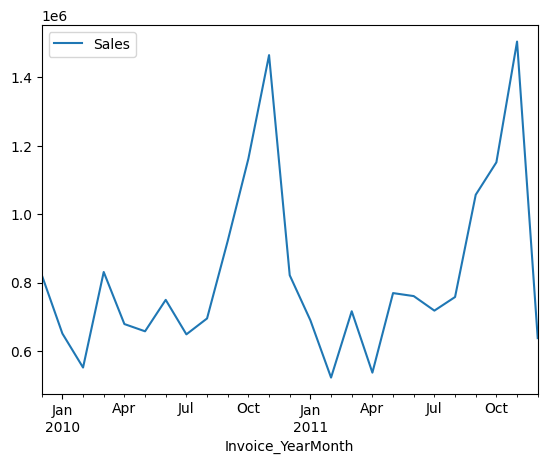

In [73]:
# Before we finish data cleaning, just to check how the data looks. And we found data drop in 2010-12, and that's because of incomplete data for that month.
Monthly_Sales.plot(x='Invoice_YearMonth',y = 'Sales')

Until here, we finish all data cleaning process. There might be some other things to check if we are doing on other dataset since different data might have different issues. But always have more observations of the data to understand what we need to do with data before modelling.

## ARIMA modelling

As mentioned earlier, one of the premises to use ARIMA is that the data is stationary. Thus, we need to check the data whether it is stationary or not. If not, we will need to set the "d" to apply differencing.

First, we can take a look at the plot. It has a clear upward trend there, so most likely the data is not stationary and we might need differencing.

<Axes: xlabel='Invoice_YearMonth'>

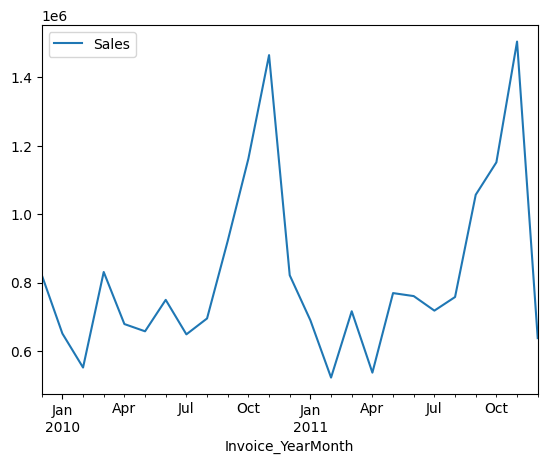

In [74]:
Monthly_Sales.plot(x='Invoice_YearMonth',y = 'Sales')

But we can also use statistical model to test the data stationary or. Here We can check this with an Augmented Dickey Fuller (ADF) test via Python's statsmodel. In this test, there are hypotheses as below:



H0: The data is non-stationary

H1: The data is stationary



If P > 0.05, then fail to reject the null hypothesis, that means the data is not stationary;

if P < 0.05, then reject the null hypthesis and the data is indeed stationary.

In [75]:
from statsmodels.tsa.stattools import adfuller

# perform ADF test - autolag with automatically identify the optimal number of lags
adf_test = adfuller(Monthly_Sales["Sales"], autolag="AIC")

# add the ouput to a series with the names of the statistics
output = pd.Series(adf_test[0:4], index=["Test statistic", "p-value", "Lags", "Observations"])

print(output)

Test statistic    -3.664491
p-value            0.004641
Lags               9.000000
Observations      15.000000
dtype: float64


Form the result we got above, p-value is slightly smaller than 0.05, but the data might be still non-stationary and needs differencing. We will use auto_arima to help us decide the parameter.

Next we will need parameters for p, d, q as we mentioned for the ARIMA model. We will use the previously installed pmdarima module (auto_arima())to test all the values for us and tell us the best parameters. This is an easy way to build ARIMA model since we do not need to find the parameters manually. We'll set maximum values of p and q parameter as 5 mostly for speed but these are decent maximums given the size of our data and quarterly pattern. And then we will use adftest to find the optimal 'd' as we discussed that the data is not stationary and needs differencing.

In [93]:
import pmdarima as pm

model = pm.auto_arima(Monthly_Sales["Sales"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=657.527, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=663.125, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=659.577, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=656.109, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=661.335, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=658.649, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=657.470, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=653.165, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=654.155, Time=0.21 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=656.107, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=657.791, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=656.085, Time=0.23 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.689 seconds
                               SARIMAX Results                                
Dep. Variable:       

The experiments identify the following parameters:
p=0
d=2
q=1

Thus, order=(0, 2, 1) will be used in the model. With these values we can fit the final model:

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# 0,2,1 ARIMA Model
model = ARIMA(Monthly_Sales["Sales"], order=(0,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   25
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -324.582
Date:                Mon, 20 May 2024   AIC                            653.165
Time:                        03:12:42   BIC                            655.436
Sample:                             0   HQIC                           653.736
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9263      0.325     -2.854      0.004      -1.562      -0.290
sigma2      1.459e+11   2.11e-12   6.92e+22      0.000    1.46e+11    1.46e+11
Ljung-Box (L1) (Q):                   0.88   Jarque-

From the result summary here, the model seems acceptable but not ideal. But usually we will compare the results by testing different parameters and then to choose the best one. But since we have already used auto_arima module to automatically find the best parameters, so we assume we have got the best model. In the real practice, it will always be worth comparing the automatic result and mannual result and then to choose a better one.

We can also print out some metrics to evaluate the performance. Here we mainly look into the errors. It might not be easy to interpret the result. We can use the result here to be divided by the average actual value ("sales" in this case) to get the percentage, so we will have some understanding whether it is acceptable or not. From this result, the model is acceptable, though not very good. This might be because the data is quite small.

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

# report performance
mse = mean_squared_error(Monthly_Sales['Sales'],model_fit.predict())
print('MSE: '+str(mse))
mae = mean_absolute_error(Monthly_Sales['Sales'],model_fit.predict())
print('MAE: '+str(mae))
mae = mean_absolute_percentage_error(Monthly_Sales['Sales'],model_fit.predict())
print('MAPE: '+str(mae))
rmse = math.sqrt(mean_squared_error(Monthly_Sales['Sales'],model_fit.predict()))
print('RMSE: '+str(rmse))

MSE: 128649379814.98376
MAE: 259714.92191404357
MAPE: 0.3488714882138073
RMSE: 358677.2641456157


In [94]:
print((259714/Monthly_Sales['Sales'].mean())) # %MAE

0.3170858060377083


In [95]:
print((358677/Monthly_Sales['Sales'].mean())) # %MAE

0.4379101074727858


Lastly we will make predictions for the next six months 01/2012-06/2012. We start by creating an empty DataFrame:

In [80]:
import numpy as np
pred = pd.concat([Monthly_Sales, pd.DataFrame({'InvoiceDate':["2012-01", "2012-02", "2012-03","2012-04", "2012-05","2012-06"],'pred':np.nan})], ignore_index=True)

In [81]:
pred[-6:]

,Invoice_YearMonth,Sales,InvoiceDate,pred
25,NaT,NaN,2012-01,NaN
26,NaT,NaN,2012-02,NaN
27,NaT,NaN,2012-03,NaN
28,NaT,NaN,2012-04,NaN
29,NaT,NaN,2012-05,NaN
30,NaT,NaN,2012-06,NaN


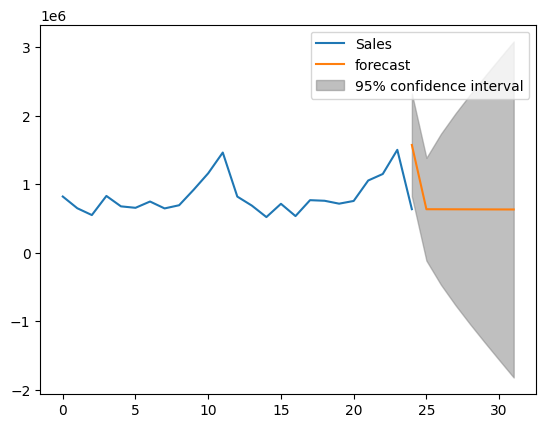

In [82]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = pred.Sales.plot(ax=ax)
plot_predict(model_fit, start=24,end=31, ax=ax)
plt.show()

Here we use ARIMA to forecast the sales, but the data clearly shows seasonality. Thus we will try SARIMA to plot out the seasonality.

In [90]:
# Seasonal - fit stepwise auto-ARIMA
# Here we set seasonal to True and m to 12 representing monthly seasonality, then to get the best parameters.
import pmdarima as pmd
smodel=pmd.auto_arima(Monthly_Sales['Sales'],start_p=1,start_q=1,d=None,test='adf',m=12,start_P=1,start_Q=1,D=1,seasonal=True,trace=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=306.088, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=302.691, Time=0.22 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=301.416, Time=0.18 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=294.160, Time=0.10 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=301.490, Time=0.19 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=294.638, Time=0.19 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=295.652, Time=0.23 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=302.544, Time=0.04 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(0,2,1)(0,1,0)[12] intercept   : AIC=304.756, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,1,0)[12]          
Total fit time: 4.815 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   25
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 12)   Log Likelihood                -145.080
Date:                             Mon, 20 May 2024   AIC                            294.160
Time:                                     03:16:24   BIC                            294.956
Sample:                                          0   HQIC                           293.658
                                              - 25                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9499      0.135     -7.030      0.000      -1.215      -0.685
sigma2       2.16e+10   8.87e-13   2.44e+22      0.000    2.16e+10    2.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.18   Prob(JB):                         0.74
Heteroskedasticity (H):               0.95   Skew:                             0.56
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+38. Standard errors may be unstable.
"""

From the above result, the best model is (0,2,1) (0,1,0,12). We will use this as the parameters of the SARIMA model.

In [85]:
# 0,2,0 ARIMA Model
import statsmodels.api as sm
smodel = sm.tsa.statespace.SARIMAX(Monthly_Sales["Sales"], order=(0,2,1), seasonal_order=(0,1,0,12))
smodel_fit = smodel.fit()
print(smodel_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   25
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 12)   Log Likelihood                -145.080
Date:                             Mon, 20 May 2024   AIC                            294.160
Time:                                     03:14:28   BIC                            294.956
Sample:                                          0   HQIC                           293.658
                                              - 25                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9499      0.135     -7.030      0.000      -1.215      -0.685
sigma2       2.16e+10   8.8

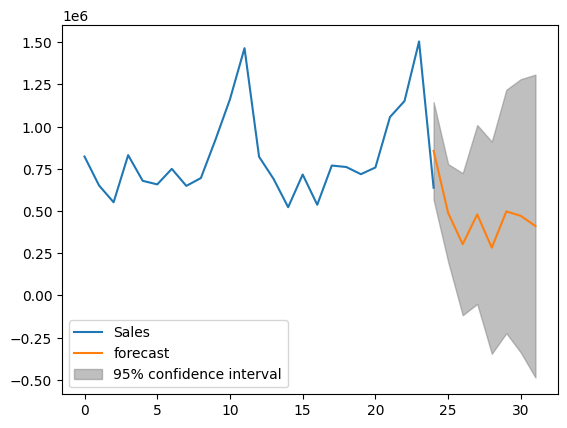

In [86]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = df1.Sales.plot(ax=ax)
plot_predict(smodel_fit, start=24,end=31, ax=ax)
plt.show()

Overall our prediction results looks sensible. Well done:)

This is the end of this tutorial. Regarding the evaluation of the result, it still will involve the understanding of the business and none of the forecast would be perfect!

You could further try to do quarterly data forecasting if you want.

Thank you for reading this tutorial.